In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

df = pd.read_csv("effectifs.csv", sep=";")

## 1. Nettoyage des données

In [2]:
# Suppression des lignes où Ntop est manquant (variable cible)
df = df.dropna(subset=["Ntop"])

# Suppression des lignes région 99 (France entière — biais pour l'analyse régionale)
df.drop(df[df["region"] == 99].index, inplace=True)

print("Shape après nettoyage :", df.shape)
print("Valeurs manquantes sur Ntop :", df["Ntop"].isnull().sum())
print("Régions présentes :", sorted(df["region"].unique()))

Shape après nettoyage : (3792196, 16)
Valeurs manquantes sur Ntop : 0
Régions présentes : [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(11), np.int64(24), np.int64(27), np.int64(28), np.int64(32), np.int64(44), np.int64(52), np.int64(53), np.int64(75), np.int64(76), np.int64(84), np.int64(93), np.int64(94)]


## 2. Agrégation et recalcul de la prévalence

On agrège les données par `(annee, region, patho_niv1)` pour se placer au bon niveau d'analyse.

La prévalence est recalculée **après nettoyage** avec la formule :

> `prevalence = ΣNtop / ΣNpop`

**Pourquoi ne pas utiliser `prev` originale ?**
- Calculée à un niveau trop fin (département + âge + sexe)
- Non comparable entre régions
- 1 382 435 valeurs NaN

Notre prévalence recalculée est au niveau région → fiable et comparable. 

In [28]:
# Agrégation par annee, region, patho_niv1
df_model = (
    df.groupby(["annee", "region", "patho_niv1"])
    .agg({"Ntop": "sum", "Npop": "sum"})
    .reset_index()
)

# Recalcul prévalence sur données propres
df_model["prevalence"] = df_model["Ntop"] / df_model["Npop"]

print("Shape df_model :", df_model.shape)
print("NaN dans prevalence :", df_model["prevalence"].isnull().sum())
df_model.head()

Shape df_model : (2826, 6)
NaN dans prevalence : 0


,annee,region,patho_niv1,Ntop,Npop,prevalence
0,2015,1,Affections de longue durée (dont 31 et 32) pou...,110620.0,3008400,0.036770
1,2015,1,Cancers,355180.0,30751080,0.011550
2,2015,1,Diabète,300900.0,2897560,0.103846
3,2015,1,Hospitalisations hors pathologies repérées (av...,388280.0,3008400,0.129065
4,2015,1,Insuffisance rénale chronique terminale,14900.0,7969480,0.001870


In [29]:
# Trier pour le lag
df_model = df_model.sort_values(["region", "patho_niv1", "annee"])

# Ajouter variables retardées (année précédente)
df_model["prev_Ntop"] = df_model.groupby(
    ["region", "patho_niv1"]
)["Ntop"].shift(1)

df_model["prev_prevalence"] = df_model.groupby(
    ["region", "patho_niv1"]
)["prevalence"].shift(1)

# Supprimer les premières années (NaN)
df_model = df_model.dropna()

In [37]:
# Features enrichies
X = df_model[[
    "annee",
    "region",
    "patho_niv1",
    "Npop",
    "prev_Ntop",
    "prev_prevalence"
]]

y = df_model["Ntop"]  # On prédit le volume

# Split temporel
train = df_model[df_model["annee"] <= 2021]
test = df_model[df_model["annee"] > 2021]

X_train = train[["annee", "patho_niv1", "region", "prev_Ntop"]]
y_train = train["Ntop"]

X_test = test[["annee", "patho_niv1", "region", "prev_Ntop"]]
y_test = test["Ntop"]

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (1854, 4)
X_test: (648, 4)


In [38]:
numerical_features = [
    "annee",
    "Npop",
    "prev_Ntop",
    "prev_prevalence"
]

categorical_features = ["patho_niv1", "region"]

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import joblib

lin_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

lin_model.fit(X_train, y_train)

y_pred_lin = lin_model.predict(X_test)

rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin = r2_score(y_test, y_pred_lin)

joblib.dump(lin_model, "linear_model.pkl")

print("Linear Regression")
print("RMSE:", rmse_lin)
print("R2:", r2_lin)

Linear Regression
RMSE: 9907141.81564209
R2: 0.10813919403846806


In [40]:
from sklearn.ensemble import RandomForestRegressor

rf_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest")
print("RMSE:", rmse_rf)
print("R2:", r2_rf)

Random Forest
RMSE: 299313.7753652503
R2: 0.9991859450358194


## 3. Transformation logarithmique de la variable cible

L'EDA a mesuré :
- Skewness Ntop : 251.92 → extrêmement asymétrique
- Skewness prevalence : 2.77 → asymétrique à droite

La variable cible retenue est `prevalence` (Ntop/Npop) car elle permet une 
comparaison équitable entre régions, sans biais de population.

On applique `log1p(prevalence)` pour corriger l'asymétrie.

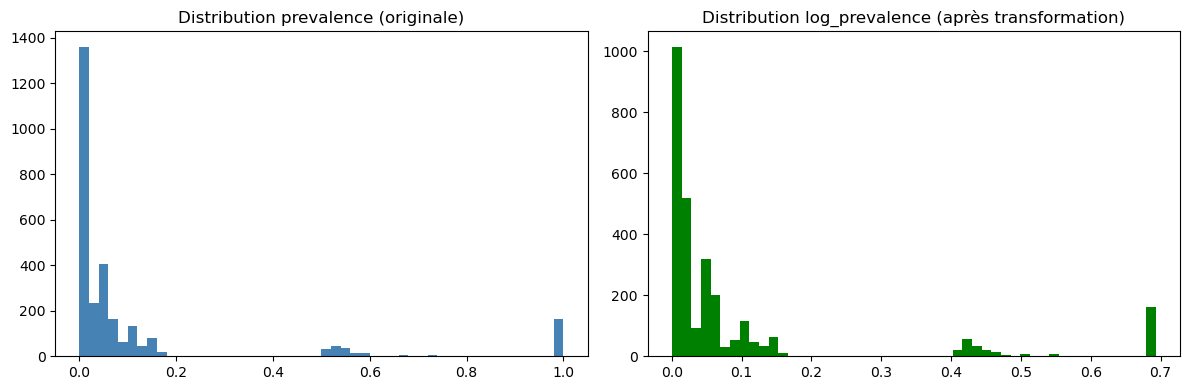

Skewness avant : 2.71
Skewness après : 2.51


In [4]:
df_model["log_prevalence"] = np.log1p(df_model["prevalence"])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df_model["prevalence"], bins=50, color='steelblue')
axes[0].set_title("Distribution prevalence (originale)")

axes[1].hist(df_model["log_prevalence"], bins=50, color='green')
axes[1].set_title("Distribution log_prevalence (après transformation)")

plt.tight_layout()
plt.show()

print(f"Skewness avant : {df_model['prevalence'].skew():.2f}")
print(f"Skewness après : {df_model['log_prevalence'].skew():.2f}")

In [5]:


numerical_features = ["annee", ] 
categorical_features = ["patho_niv1", "region"]

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder())
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numerical_features),
    ("cat", categorical_pipeline, categorical_features)
])

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor)
])
print(pipeline)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['annee']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['patho_niv1', 'region'])]))])


## 4. Pipeline de preprocessing + split train/test


In [22]:
# SPLIT TEMPOREL

X = df_model[["annee", "patho_niv1", "region"]]
y = df_model["log_prevalence"]

# Train : 2015–2021
train = df_model[df_model["annee"] <= 2021]
# Test : 2022–2023
test = df_model[df_model["annee"] > 2021]

X_train = train[["annee", "patho_niv1", "region"]]
y_train = train["log_prevalence"]

X_test = test[["annee", "patho_niv1", "region"]]
y_test = test["log_prevalence"]

print("X_train :", X_train.shape)
print("X_test :", X_test.shape)

X_train : (2178, 3)
X_test : (648, 3)


In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import joblib

lin_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

lin_model.fit(X_train, y_train)

y_pred_lin = lin_model.predict(X_test)

rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin = r2_score(y_test, y_pred_lin)

joblib.dump(lin_model, "linear_model.pkl")

print("Linear Regression")
print("RMSE:", rmse_lin)
print("R2:", r2_lin)

Linear Regression
RMSE: 0.16522613887801088
R2: 0.1225657931152736


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest")
print("RMSE:", rmse_rf)
print("R2:", r2_rf)

Random Forest
RMSE: 0.0037801740080195332
R2: 0.9995407167188125


In [25]:
print(df_model.groupby(["annee","region","patho_niv1"]).size().value_counts())

1    2826
Name: count, dtype: int64


In [10]:
joblib.dump(rf_model, "random_forest.pkl")

loaded_model = joblib.load("random_forest.pkl")
print("R2 (reloaded):", r2_score(y_test, loaded_model.predict(X_test)))

R2 (reloaded): 0.9998757404511044


In [18]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", GradientBoostingRegressor(
        random_state=42
    ))
])

gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print("Gradient Boosting")
print("RMSE:", rmse_gb)
print("R2:", r2_gb)

Gradient Boosting
RMSE: 0.011002146150762858
R2: 0.9961094421911685


In [41]:
import numpy as np
y_shuffle = np.random.permutation(y_train)

rf.fit(X_train_scaled, y_shuffle)

print(r2_score(y_test, rf.predict(X_test_scaled)))

NameError: name 'rf' is not defined

In [12]:
joblib.dump(gb_model, "gradient_boosting.pkl")

['gradient_boosting.pkl']